<a href="https://colab.research.google.com/github/dannymorris/abndistro2/blob/master/Rmd/gluonts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

This notebook demonstrates the basic usage of GluonTS for probabilistic, deep learning-based time series forecasting. Unlike traditional univariate forecasting models, recent deep learning-based models are capable of training entire collections of time series (i.e. multivariate) jointly in a single, global model.

[Docs](https://ts.gluon.ai/) 

[Paper](https://arxiv.org/pdf/1906.05264.pdf)

## Use case

Multivariate training and inference using monthly return turnover data in CSV format is the use case shown in this notebook. 

## Package installations

In [3]:

!pip install gluonts
!pip install mxnet

     |████████████████████████████████| 901kB 8.8MB/s 
     |████████████████████████████████| 10.1MB 24.7MB/s 
     |████████████████████████████████| 46.9MB 90kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Load packages

In [107]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

import mxnet as mx
from mxnet import gluon
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator

## Data

In [12]:
df = pd.read_csv("https://raw.githubusercontent.com/dannymorris/abndistro2/master/data/aus_sales.csv")
df = df.set_index('Month')

df.head()

,Australian_Capital_Territory_Cafes__restaurants_and_catering_services,Australian_Capital_Territory_Cafes__restaurants_and_takeaway_food_services,Australian_Capital_Territory_Clothing__footwear_and_personal_accessory_retailing,Australian_Capital_Territory_Clothing_retailing,Australian_Capital_Territory_Department_stores,Australian_Capital_Territory_Electrical_and_electronic_goods_retailing,Australian_Capital_Territory_Food_retailing,Australian_Capital_Territory_Footwear_and_other_personal_accessory_retailing,Australian_Capital_Territory_Furniture__floor_coverings__houseware_and_textile_goods_retailing,Australian_Capital_Territory_Hardware__building_and_garden_supplies_retailing,Australian_Capital_Territory_Household_goods_retailing,Australian_Capital_Territory_Liquor_retailing,Australian_Capital_Territory_Newspaper_and_book_retailing,Australian_Capital_Territory_Other_recreational_goods_retailing,Australian_Capital_Territory_Other_retailing,Australian_Capital_Territory_Other_retailing_n_e_c_,Australian_Capital_Territory_Other_specialised_food_retailing,Australian_Capital_Territory_Pharmaceutical__cosmetic_and_toiletry_goods_retailing,Australian_Capital_Territory_Supermarket_and_grocery_stores,Australian_Capital_Territory_Takeaway_food_services,New_South_Wales_Cafes__restaurants_and_catering_services,New_South_Wales_Cafes__restaurants_and_takeaway_food_services,New_South_Wales_Clothing__footwear_and_personal_accessory_retailing,New_South_Wales_Clothing_retailing,New_South_Wales_Department_stores,New_South_Wales_Electrical_and_electronic_goods_retailing,New_South_Wales_Food_retailing,New_South_Wales_Footwear_and_other_personal_accessory_retailing,New_South_Wales_Furniture__floor_coverings__houseware_and_textile_goods_retailing,New_South_Wales_Hardware__building_and_garden_supplies_retailing,New_South_Wales_Household_goods_retailing,New_South_Wales_Liquor_retailing,New_South_Wales_Newspaper_and_book_retailing,New_South_Wales_Other_recreational_goods_retailing,New_South_Wales_Other_retailing,New_South_Wales_Other_retailing_n_e_c_,New_South_Wales_Other_specialised_food_retailing,New_South_Wales_Pharmaceutical__cosmetic_and_toiletry_goods_retailing,New_South_Wales_Supermarket_and_grocery_stores,New_South_Wales_Takeaway_food_services,...,Victoria_Cafes__restaurants_and_catering_services,Victoria_Cafes__restaurants_and_takeaway_food_services,Victoria_Clothing__footwear_and_personal_accessory_retailing,Victoria_Clothing_retailing,Victoria_Department_stores,Victoria_Electrical_and_electronic_goods_retailing,Victoria_Food_retailing,Victoria_Footwear_and_other_personal_accessory_retailing,Victoria_Furniture__floor_coverings__houseware_and_textile_goods_retailing,Victoria_Hardware__building_and_garden_supplies_retailing,Victoria_Household_goods_retailing,Victoria_Liquor_retailing,Victoria_Newspaper_and_book_retailing,Victoria_Other_recreational_goods_retailing,Victoria_Other_retailing,Victoria_Other_retailing_n_e_c_,Victoria_Other_specialised_food_retailing,Victoria_Pharmaceutical__cosmetic_and_toiletry_goods_retailing,Victoria_Supermarket_and_grocery_stores,Victoria_Takeaway_food_services,Western_Australia_Cafes__restaurants_and_catering_services,Western_Australia_Cafes__restaurants_and_takeaway_food_services,Western_Australia_Clothing__footwear_and_personal_accessory_retailing,Western_Australia_Clothing_retailing,Western_Australia_Department_stores,Western_Australia_Electrical_and_electronic_goods_retailing,Western_Australia_Food_retailing,Western_Australia_Footwear_and_other_personal_accessory_retailing,Western_Australia_Furniture__floor_coverings__houseware_and_textile_goods_retailing,Western_Australia_Hardware__building_and_garden_supplies_retailing,Western_Australia_Household_goods_retailing,Western_Australia_Liquor_retailing,Western_Australia_Newspaper_and_book_retailing,Western_Australia_Other_recreational_goods_retailing,Western_Australia_Other_retailing,Western_Australia_Other_retailing_n_e_c_,Western_Australia_Other_specialised_

In [21]:
print("N rows:", df.shape[0])
print("N cols:", df.shape[1])
print("Column types:", df.dtypes.unique())

N rows: 441
N cols: 152
Column types: [dtype('float64')]


## Define model data

This dictionary containing metadata about the model is created out of convenience and for reuse. The metadata defines the interval between the time steps (1 month) and the desired prediction length (12 months).

In [22]:
metadata = {
    'prediction_length': 12,
    'freq': '1M'
}

## Training and testing data

The pandas DataFrame with *N* time series is converted to a dictionary with length *N* with, at a minimum, `start` and `target` keys for each individual time series. The `start` key defines the start date of the individual time series, and the `target` key contains the individual time series values. The complete list of available keys, including keys for adding features, is shown [here](https://ts.gluon.ai/tutorials/forecasting/extended_tutorial.html#Use-your-time-series-and-features).

The dictionary with length *N* is then converted to a `ListDataset` for use with GluonTS. 

In [24]:
train_data = [{"start": df.index[0], "target": df[i].values[:-metadata['prediction_length']]} for i in df.columns]
test_data = [{"start": df.index[0], "target": df[i].values} for i in df.columns]

train_ds = ListDataset(
    data_iter=train_data,
    freq=metadata['freq']
)

test_ds = ListDataset(
    data_iter=test_data,
    freq=metadata['freq']
)


In [90]:
print("N time series in original pandas DataFrame:", df.shape[1])
print("N entries in training data dictionary:", len(train_data), "\n")
print("Example dictionary format of a single time series: \n\n", train_data[0])

N time series in original pandas DataFrame: 152
N entries in training data dictionary: 152 

Example dictionary format of a single time series: 

 {'start': '1982-04-01', 'target': array([ 4.4,  3.4,  3.6,  4. ,  3.6,  4.2,  4.8,  5.4,  6.9,  3.8,  4.2,
        4. ,  4.4,  4.3,  4.3,  4.6,  4.9,  4.5,  5.5,  6.7,  9.6,  3.8,
        3.8,  4.4,  3.8,  3.9,  4.1,  4.3,  4.8,  5. ,  5.3,  5.6,  6.8,
        4.6,  4.3,  4.3,  6. ,  5.8,  5.9,  6.4,  7. ,  6.7,  6.7,  6.8,
        7.6,  7.9,  6.1,  9.3,  7. ,  7.5,  6.2,  9.8,  9.1,  9. ,  9.2,
        9. , 11.1,  8.2,  7.9,  9. ,  9.3,  9. ,  8.9,  8.7,  8.6,  9.1,
       10.8,  9.4, 12.6,  8.6,  8.7,  9.5,  9.6,  9. , 10.2, 10.3, 11.7,
       11.4, 11. , 11.5, 11.5,  9.5,  8.4,  9.1,  8. ,  9.3,  7.9,  8.9,
        8.9,  8.1,  7.8,  8.3,  8.9,  8.3,  8. ,  9.3,  8.9,  9.4,  9.6,
       10.3,  9.8, 12.3, 11.1, 11.7, 11.2,  9.7, 11.1,  9.8, 10. , 10.5,
       10. , 10.5, 11.2, 12.2, 14.9, 14.9, 14. , 10.5,  9.9, 12.8, 12.1,
       12.9, 13.

## Sample time series visualization

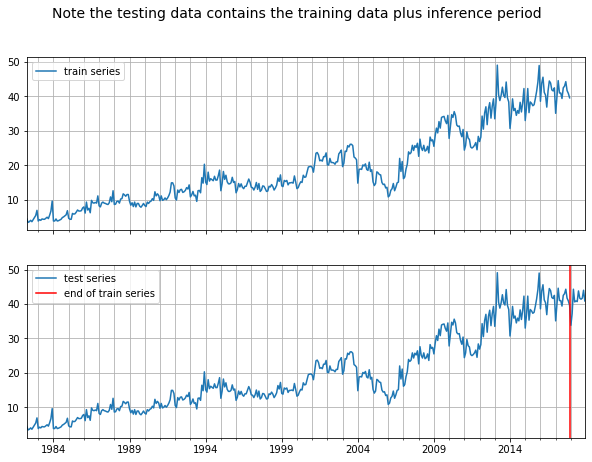

In [33]:
train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.suptitle("Note the testing data contains the training data plus inference period", fontsize=14)
plt.show()

## Define an Estimator

Estimator objects represent a forecasting model as well as details such as its coefficients, weights, etc. This example uses the `SimpleFeedForwardEstimator`, a pre-built feedforward neural network.

[Docs](https://ts.gluon.ai/api/gluonts/gluonts.model.simple_feedforward.html)

In [94]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=metadata['prediction_length'],
    context_length=2*metadata['prediction_length'],
    freq=metadata['freq'],
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

## Fit Estimator to training data

In [95]:
%%time
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 73.77it/s, epoch=5/5, avg_epoch_loss=3.52]

CPU times: user 7.96 s, sys: 592 ms, total: 8.56 s
Wall time: 6.88 s


## Make predictions

In [96]:
%%time
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor, 
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

CPU times: user 867 ms, sys: 5.89 ms, total: 873 ms
Wall time: 865 ms


In [101]:
print("N forecasted time series:", len(forecasts))

N forecasted time series: 152


gluonts.model.forecast.SampleForecast(freq="1M", info=None, item_id=None, samples=numpy.array([[35.895904541015625, 41.11286544799805, 64.52651977539062, 39.908016204833984, 47.209129333496094, 48.390625, 26.337268829345703, 53.86824035644531, 46.12324142456055, 54.17097091674805, 53.492210388183594, 44.47274398803711], [32.596466064453125, 42.972320556640625, 41.287689208984375, 39.05728530883789, 46.970516204833984, 46.42560577392578, 44.725608825683594, 39.520687103271484, 45.13923263549805, 49.774314880371094, 47.6370849609375, 46.25996017456055], [34.70705795288086, 47.19486618041992, 44.53343963623047, 41.70600891113281, 30.614288330078125, 40.77232360839844, 44.03398895263672, 51.69086456298828, 44.658966064453125, 42.599735260009766, 35.01732635498047, 49.1939697265625], [29.000648498535156, 41.52207946777344, 48.6276741027832, 53.69927215576172, 40.765323638916016, 40.33871841430664, 42.264991760253906, 49.060482025146484, 51.46433639526367, 52.740943908691406, 52.050598144531

## Accuracy metrics

In [111]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
item_metrics

Running evaluation: 100%|██████████| 152/152 [00:00<00:00, 5381.90it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,12.686667,41.895370,491.000000,40.916667,2.970744,1.175221,0.085767,0.081572,NaN,8.117862,8.191451,0.083333,41.895370,1.000000,21.960556,1.000000
1,NaN,16.580092,42.711246,807.899963,67.324997,3.494964,1.018400,0.054119,0.052251,NaN,11.537834,13.134641,0.083333,42.711246,1.000000,31.216338,1.000000
2,NaN,5.825918,26.567251,461.099976,38.424998,1.469065,1.507039,0.056980,0.055999,NaN,19.268950,14.581358,0.000000,26.567251,0.583333,14.780661,1.000000
3,NaN,3.299266,17.752663,288.399994,24.033333,1.221343,1.211280,0.058868,0.060083,NaN,12.077488,10.496801,0.000000,17.752663,0.333333,7.678024,0.916667
4,NaN,20.138700,51.867836,366.300018,30.525002,1.401679,3.083674,0.147693,0.135857,NaN,16.706654,13.696942,0.333333,51.867834,0.916667,21.647902,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,NaN,181.363261,139.632874,1683.500122,140.291677,6.804556,1.710042,0.087025,0.082423,NaN,13.636516,30.535481,0.083333,139.632874,1.000000,83.963736,1.000000
148,NaN,11.318152,31.428215,1045.099976,87.091665,5.617986,0.466184,0.030052,0.029760,NaN,8.773043,29.235130,0.000000,31.428215,0.333333,29.773882,1.000000
149,NaN,101.311188,117.493713,1813.900024,151.158335,6.028057,1.624262,0.066672,0.063898,NaN,15.444216,34.475691,0.000000,117.493713,0.916667,76.346927,1.000000
150,NaN,5671.687500,715.622498,11714.599609,976.216634,25.140049,2.372120,0.061731,0.059503,NaN,26.534749,202.628467,0.000000,715.622498,1.000000,519.070154,1.000000


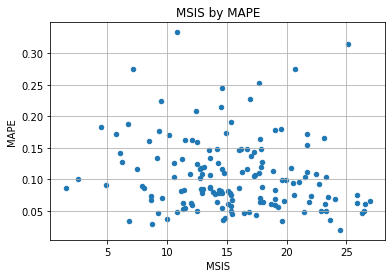

In [115]:
item_metrics.plot(x='MSIS', y='MAPE', kind='scatter')
plt.grid(which="both")
plt.title("MSIS by MAPE")
plt.show()

## Plot forecasts

A sample of 20 out of 152 time series is shown.

In [71]:
def plot_prob_forecasts(ts, forecast, title):
    plot_length = 100
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts[-plot_length:].plot(ax=ax)  # plot the time series
    forecast.plot(prediction_intervals=prediction_intervals, color='g')
    plt.legend(legend, loc="upper left")
    fig.suptitle("Time series:" + title)
    plt.show()

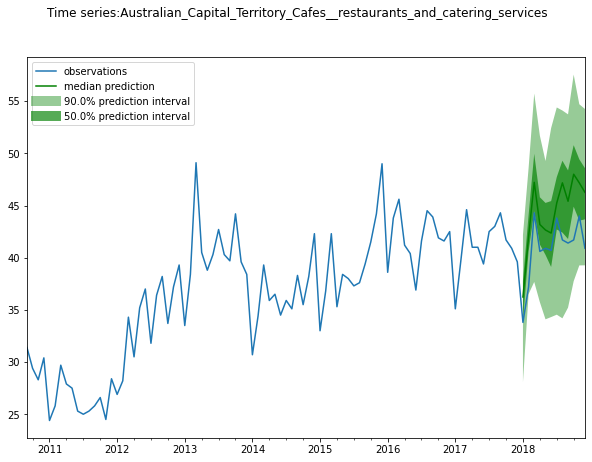

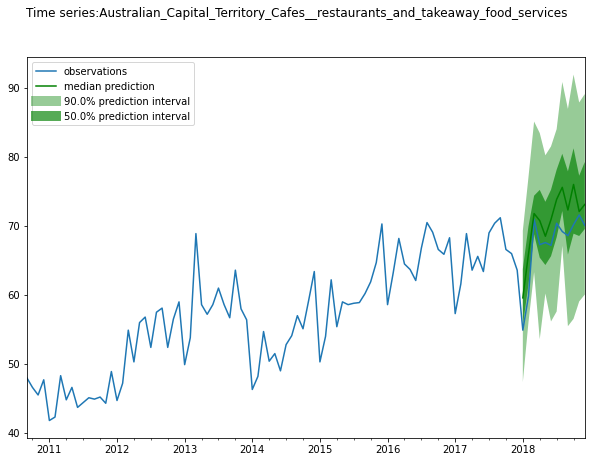

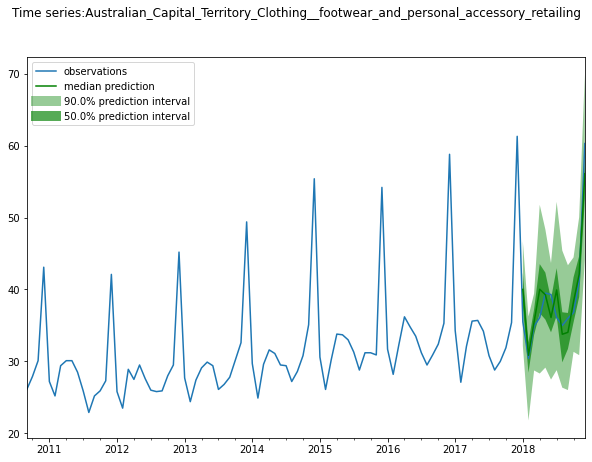

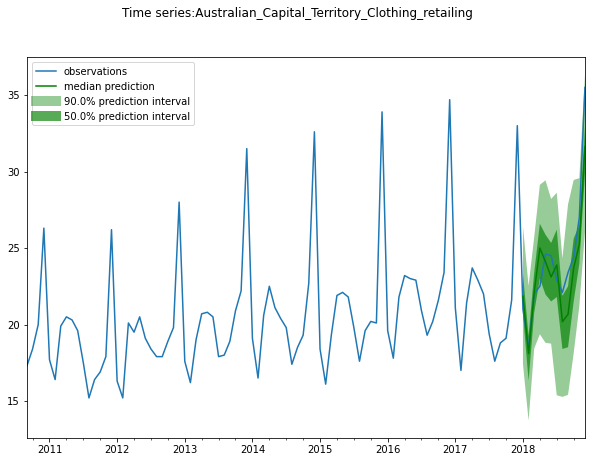

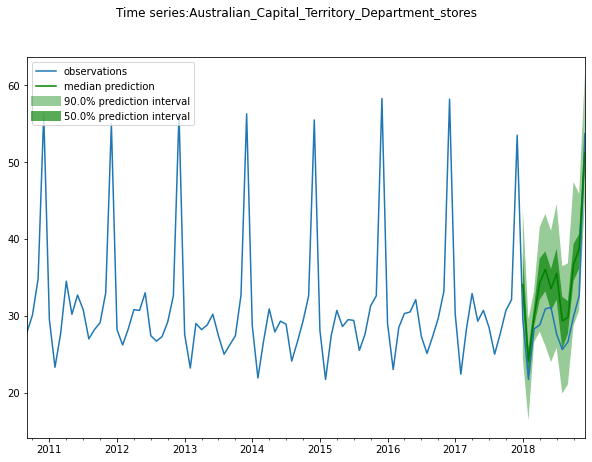

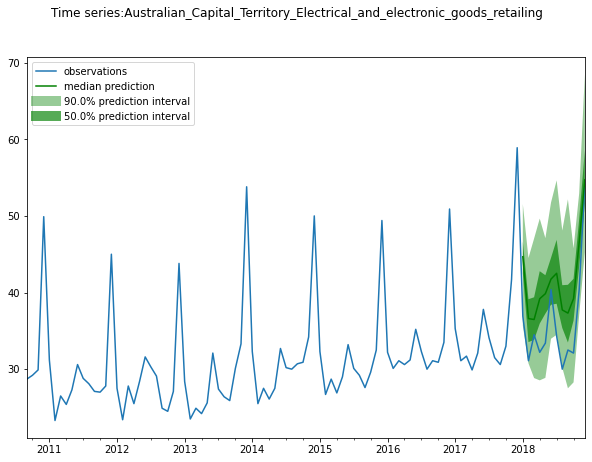

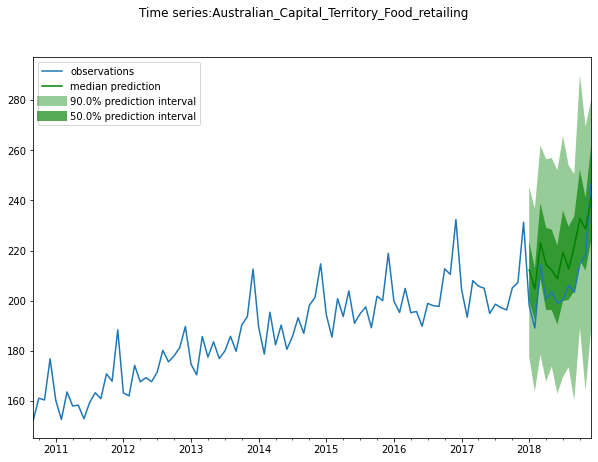

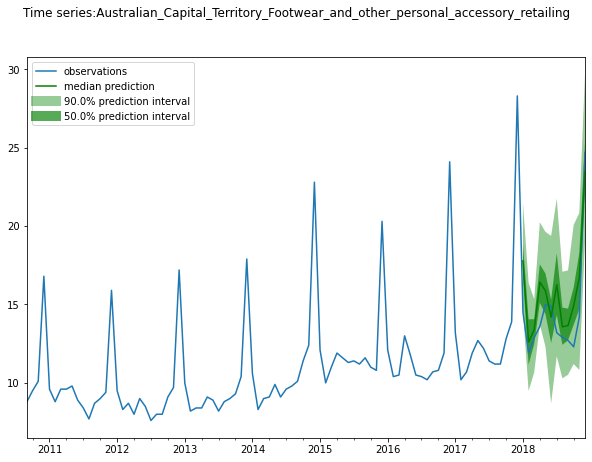

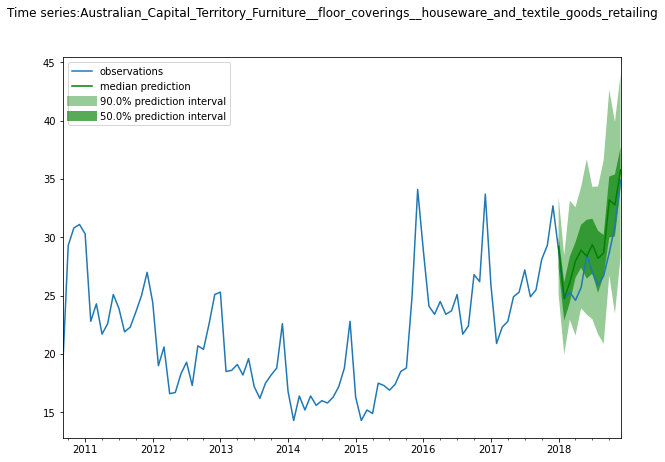

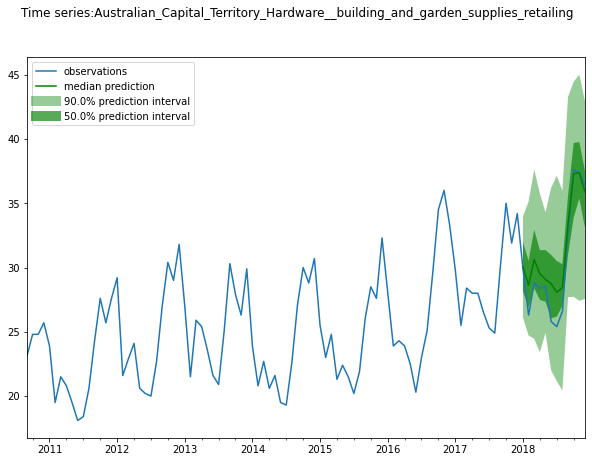

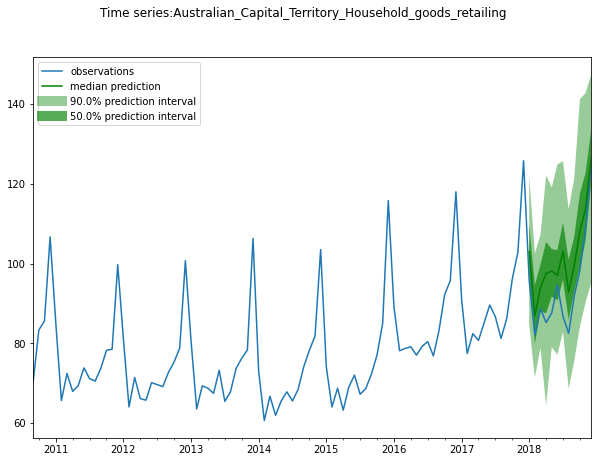

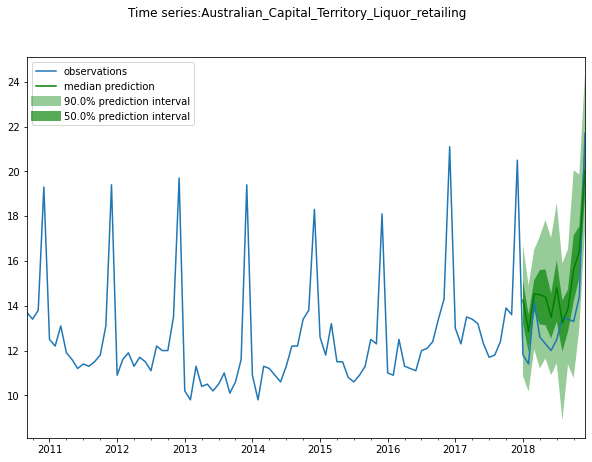

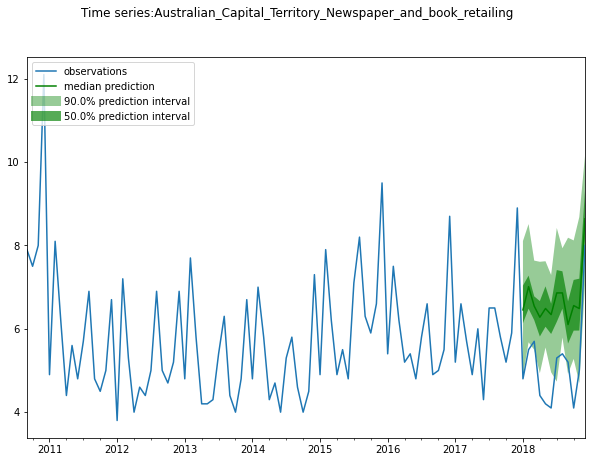

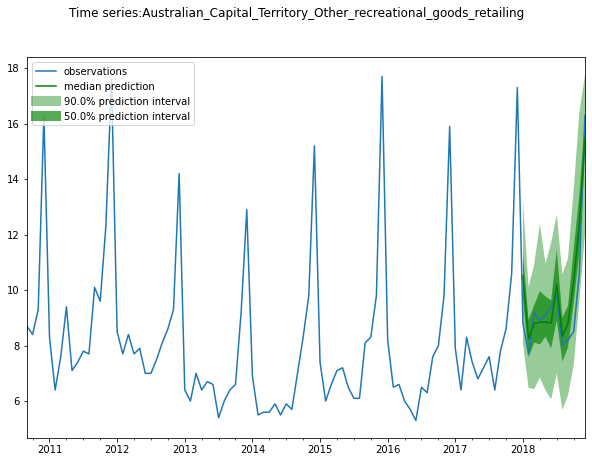

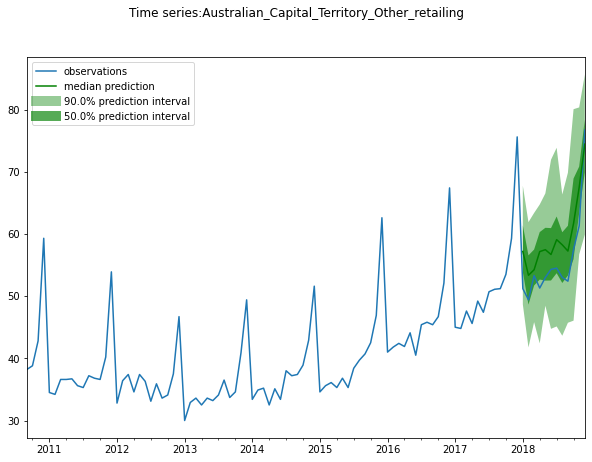

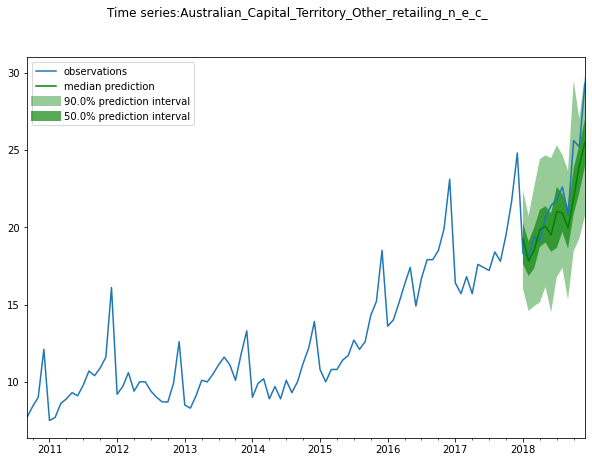

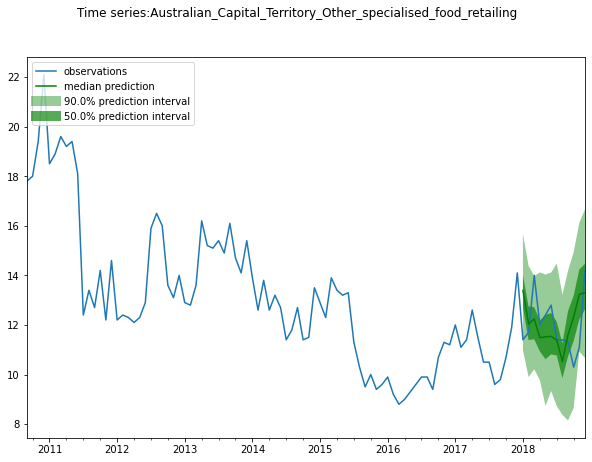

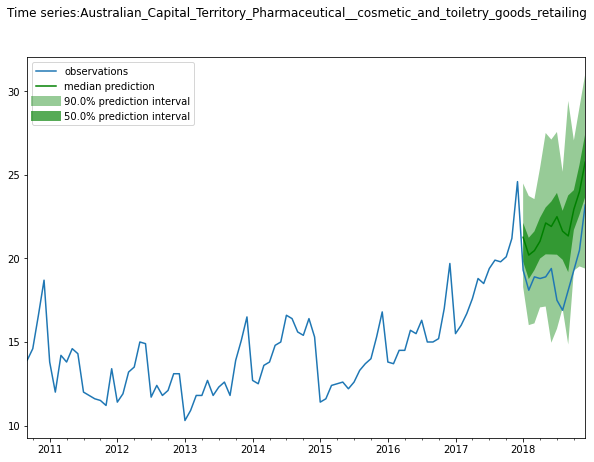

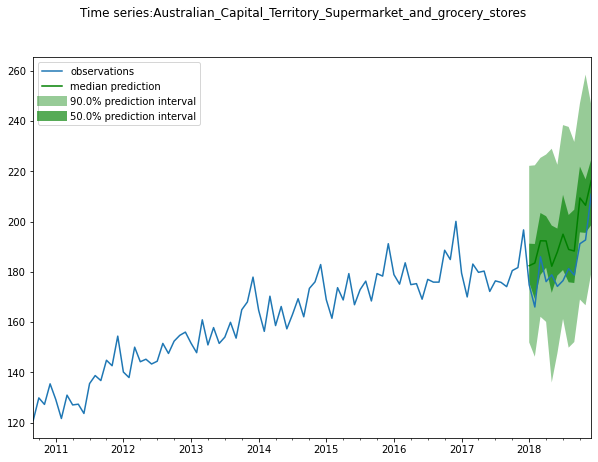

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [117]:
ts_sample = list(range(0,19))

[plot_prob_forecasts(tss[i], forecasts[i], df.columns[i]) for i in ts_sample]